# Vaccines Global Trade Network: Analysis & Forecasting with ARIMA and Holt-Winters Exponential Smoothing

#### Author: Georgios Spyrou (https://github.com/gpsyrou)
#### Latest Update: 17/08/2021

<img src="https://www.our-voices.org.uk/assets/images/Network-diagram.png" width=520 height=240 />

## Sections

- <a href='#project_purpose' style="text-decoration: none\">Description</a>
- <a href='#data_retrieval' style="text-decoration: none\">Part 1: Data Retrieval</a>
- <a href='#data_cleaning_and_eda' style="text-decoration: none\">Part 2: Data Cleaning and Exploratory Data Analysis</a>
- <a href='#forecasting_models' style="text-decoration: none\">Part 3: Time Series Analysis: Forecasting Models</a>
    - <a href='#arima' style="text-decoration: none\">Autoregressive Integrated Moving Average (ARIMA)</a>
        - <a href='#arima_definition' style="text-decoration: none\">ARIMA definition</a>
        - <a href='#autocorel_lag_plot' style="text-decoration: none\">Autocorrelation, Lag Plot and Stationarity</a>
        - <a href='#arima_creation' style="text-decoration: none\">Creating, Fitting and Tuning the Model</a>
        - <a href='#arima_results' style="text-decoration: none\">Results</a>
    - <a href='#hwes' style="text-decoration: none\">Holt-Winters Exponential Smoothing (HWES)</a>
        - <a href='#hwes_definition' style="text-decoration: none\">HWES definition</a>
        - <a href='#hwes_creation' style="text-decoration: none\">Creating a HWES model</a>
        - <a href='#hwes_results' style="text-decoration: none\">Results</a>
- <a href='#conclusion' style="text-decoration: none\">Part 4: Comparison of the models</a>

<a id="project_purpose"></a>
## Description

Scope of this project is to replicate the global trade network of human vaccines around the globe for a variety of years (current data span from 2010 to 2019). Through plotting and statistical analysis, we want to identify informative patterns on how different countries change their import/export activity throughout the years. We will use a variety of visualization tools and plots to get a better understanding of the main importers/exporters of vaccines, identify pairs of countries that tend to trade with each other regularly, and more. Finally, by using observations from the aforementioned timeframe we will attempt to predict future values of the trade activity between any two pair of countries. Specifically, we will use the trade value of vaccines from 2010 to 2019 and create two forecasting models, which will allow us to predict the monthly trade values for 2020 between United Kingdom and USA.

<a id="data_retrieval"></a>
## Part 1: Data Retrieval

In order to find and retrieve data we have utilised the UN Comtrade API (https://comtrade.un.org/Data ). This is a great place if someone wants to find data regarding exports/impors of countries around the world, pretty much for any product/service. The data are very well documented and visualized on the website and it's easy to do some exploration and locate data that seem interesting for your project.

Therefore, after we managed to identify the relevant data that we wanted to work with (vaccines for human medicine), we had to find a way to leverage the API to actually get the data into a reusable format - i.e. flat files/csv. Even though the website allows us to download sample CSV files, if we wanted to do that for multiple years and countries it would take a lot of time. Hence, we have decided to approach the data retrieval from an automation standpoint to avoid doing this manually.

Before we jump to the part of how we are going to automate the data retrieval, it might worths it to explain what exactly we are aiming to retrieve.


The UN Comtrade database is giving us the opportunity to pick data for a plethora of goods and services. The first task is to find the specific code that corresponds to human vaccines. After a bit of research we have found that this code is *300220*, which is a unique value that will allow us to only pick data for this good/product. Afterwards, we have to decide on the time range that we want to pick data for. This can quickly get tricky as the database does not allow you to pick many years/countries all at once. But for now lets say that the scope of interest was *monthly* data from 2010 to 2019, for as many countries as possible - mainly because there are countries which do not seem to import/export vaccines on a specific year or there is no relevant information about them for that year.

After we set up the string that will be used to do the appropriate API calls, it's time create a function that will use this string to retrieve the data and generate the csv files.

Note that this call will run for *each* country, therefore we will end up with a lot of csv files. The country codes can be found here: https://comtrade.un.org/Data/cache/reporterAreas.json

At this point, we have successfully get the data for every country that we cound find a corresponding country code for. That said, as we mentioned before there are some countries that contain no data for a specific year - which is might be for many reasons but this is out of the scope of this project. 

As you can probably imagine this process generated over 1000 csv files (10 years x over 100 countries). Hence it was necessary to perform some data cleaning operations in the directory that the files were created. The main task was to merge all this files for a specific year (e.g. all countries for 2017 merged to a common csv file, etc) and at the same time delete all the files from the directory that contained no data.

In order to do that we have created a script to automatically do this for us, but as it might not be a very interesting task we are going to leave it outside of this notebook. The code that completes the csv cleaning task can be found here: https://github.com/gpsyrou/Vaccines_Trade_Network/blob/master/data_cleaning.py

<a id="data_cleaning_and_eda"></a>
## Part 2: Exploratory Data Analysis & Data Cleaning

Now that we have our data organized into separate CSV files by year, we can start the task of exploring what we actually got from the data retrieval process.

**Note**: Frow now on you are going to see two packages, one named <em>**trade_network_functions**</em> and one named **_VaccinesTradeNetworkClass_**. Please note that these are custom packages that I have created for the purposes of this project. The first one contains some functions that we will keep using for the Exploratory Data Analysis (EDA) part, while the VaccinesTradeNetworkClass one will be used later on, when we jump into creating out network graph as well as the time series objects.

In [166]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from typing import List

# Plotting and graphs
import matplotlib.pyplot as plt
import seaborn as sns

project_dir = r"D:\GitHub\Projects\Comtrade_Network"
os.chdir(project_dir)

In [167]:
# Custom packages
from utilities import trade_network_functions as tnf
from VaccinesTradeNetworkClass import VaccinesTradeNetwork

In [168]:
csv_files_loc = os.path.join(project_dir, "Merged_CSVs")

vaccines_df_full = pd.concat([pd.read_csv(os.path.join(csv_files_loc, file)) for file in os.listdir(csv_files_loc)])

At this stage we need to explore the dataset and identify any potential issues in the data that require cleaning, and also make sure that we understand the features. Initially, we can check the size of our dataset, and how the instances vary depending on the year.

In [169]:
vaccines_df_full.shape

(190076, 35)

In [170]:
vaccines_df_full.groupby(['Year']).size().reset_index(name='Counts')

,Year,Counts
0,2010,16340
1,2011,17281
2,2012,16851
3,2013,16844
4,2014,17642
5,2015,19001
6,2016,19289
7,2017,19568
8,2018,19054
9,2019,13737


In [171]:
vaccines_df_full.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Year,190076.0,2.014948e+03,3.053066e+00,2010.0,2012.0,2015.0,2017.00,2.020000e+03
Period,190076.0,2.015013e+05,3.052792e+02,201001.0,201210.0,201507.0,201712.00,2.020120e+05
Aggregate Level,190076.0,6.000000e+00,0.000000e+00,6.0,6.0,6.0,6.00,6.000000e+00
Is Leaf Code,190076.0,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.00,1.000000e+00
Trade Flow Code,190076.0,1.571108e+00,5.340240e-01,1.0,1.0,2.0,2.00,4.000000e+00
Reporter Code,190076.0,4.307533e+02,2.699825e+02,8.0,208.0,392.0,699.00,8.940000e+02
Reporter ISO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Partner Code,190076.0,3.838765e+02,2.804407e+02,0.0,124.0,368.0,643.00,8.990000e+02
Partner ISO,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2nd Partner Code,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see from the summary, few of the features do not seem to provide useful information for our analysis, as they either contain only empty values (e.g. 'Qty') or they contain fixed values (e.g.'Aggregate Level'). Therefore we will exclude the useless columns from our dataset to reduce the noise and the dimensions of the feature space.

Note: More information regarding the feautures can be found here: https://comtrade.un.org/data/MethodologyGuideforComtradePlus.pdf

In [172]:
useful_features = ['Year', 'Period', 'Reporter Code', 'Reporter', 'Partner Code', 'Partner',
                   'Trade Flow', 'Commodity', 'Netweight (kg)', 'Trade Value (US$)']

vaccines_df_reduced = vaccines_df_full[useful_features]

In [173]:
vaccines_df_reduced['Trade Flow'].unique()

array(['Imports', 'Exports', 'Re-exports', 'Re-imports'], dtype=object)

We will consider both 'Re-imports' and 'Re-exports' as 'Imports' and 'Exports' respectively and we will drop the entries where we dont have info about the trade flow.

In [174]:
trade_flow_dict = {'Re-imports':'Imports', 
                   'Re-exports':'Exports',
                   'Imports':'Imports', 
                   'Exports':'Exports'}

vaccines_df_reduced['Trade Flow'] = vaccines_df_reduced['Trade Flow'].map(trade_flow_dict)

In [175]:
vaccines_df_reduced.Partner.unique()

vaccines_df_reduced['Partner'].replace(
    to_replace='United States of America',
    value='USA',
    inplace=True
)

vaccines_df_reduced['Reporter'].replace(
    to_replace='United States of America',
    value='USA',
    inplace=True
)

By looking at the data we can observe a node that is called 'World', but we would like to  analyze the trade relationships between specific countries. Thus we will exclude from the analysis the cases where the reporter or partner is 'World'. Finally, **Period** will be main the datetime column.

In [176]:
vaccines_df_reduced = vaccines_df_reduced[vaccines_df_reduced.Partner != 'World']

In [177]:
vaccines_df_reduced['Period'] = pd.to_datetime(vaccines_df_reduced['Period'], format='%Y%m')

In [178]:
vaccines_df_reduced.shape

(171125, 10)

In [179]:
vaccines_df_reduced.reset_index(drop=True, inplace=True)

In [180]:
vaccines_df_reduced.head()

,Year,Period,Reporter Code,Reporter,Partner Code,Partner,Trade Flow,Commodity,Netweight (kg),Trade Value (US$)
0,2010,2010-09-01,12,Algeria,699,India,Imports,Vaccines; for human medicine,3.0,437
1,2010,2010-10-01,12,Algeria,124,Canada,Imports,Vaccines; for human medicine,2584.0,4607945
2,2010,2010-10-01,12,Algeria,208,Denmark,Imports,Vaccines; for human medicine,1080.0,361394
3,2010,2010-10-01,12,Algeria,251,France,Imports,Vaccines; for human medicine,12454.0,5006130
4,2010,2010-10-01,12,Algeria,699,India,Imports,Vaccines; for human medicine,12978.0,1523850


In [181]:
year_counts = vaccines_df_reduced.groupby(['Year']).size().reset_index(name='Counts')
num_countries = vaccines_df_reduced.groupby('Year')['Reporter'].nunique().reset_index(name='Number of Unique Countries')

year_counts.set_index('Year').join(num_countries.set_index('Year'))

,Counts,Number of Unique Countries
Year,,
2010,14638,100
2011,15511,100
2012,15173,102
2013,15167,93
2014,15889,100
2015,17022,118
2016,17323,115
2017,17701,104
2018,17191,108


Except the nodes that correspond to countries, the other main features of interest are the **Netweight** of the export/import in kilograms as well as the **Trade Value in US dollars($)** (which will be the main feature of this project).

Now we are in a position where we can start the data visualization part, to get a better understanding of the dataset. Therefore, lets find the top countries that import/export vaccines in terms of US dollars($).

To do that, its necessary to introduce two functions that we will use for the EDA part. One function is being used in order to calculate the statistics of interest, while the second one is to plot the results. Both of these functions are packaged in <em>trade_network_functions</em> as we mentioned above, but as they might be interesting we are also going to include them into this notebook.

In [182]:
def get_aggregate_statistics(
    df: pd.core.frame.DataFrame,
    feature: str,
    kind: str,
    year: str) -> pd.core.frame.DataFrame:
    """ Given a dataframe and a feature column (numerical), identify the top
    importers/exporters by aggregating on feature and return a sorted dataframe based
    on this feature.
    
    Args:
    ----
        df: DataFrame that contains the data and the required features.
        feature: Numerical feature to aggregate (e.g. 'Trade Value (US$)', 'Netweight (kg)')
        kind: 'Imports', 'Exports'
        year: Specify year of interest or 'all' for all years.
    Returns:
    -------
        df_sorted: Sorted dataframe that contains the aggregated values.
    """
    if year == 'all':
        df = df.loc[df['Trade Flow'] == kind, [feature,
            'Year', 'Reporter']].groupby(['Year', 'Reporter']).agg(['sum']).reset_index()
    else:
        df = df.loc[(df['Trade Flow'] == kind) &
                    (df['Period'] > f'{year}-01-01') & (df['Period'] <= f'{year}-12-31'), 
                    [feature,'Reporter']].groupby(['Reporter']).agg(['sum']).reset_index()
    
        df['Year'] = int(year)

    df_sorted = df.sort_values(by=(feature,'sum'), ascending=False)
    
    return df_sorted

In [183]:
def barplot_topn_countries(
    df: pd.core.frame.DataFrame,
    feature: str,
    topn: int, 
    kind: str, 
    year: str, 
    figsize=(12,6)) -> None:    
    """ Create a bar plot of the top-N countries based on an aggregated column.        
    """
    if kind != 'Import' and kind != 'Export':
        raise ValueError('Trade flow is not set to Import or Export')

    plt.figure(figsize=figsize)
    g = sns.barplot(x='Reporter', y=(feature,'sum'), data=df[0:topn],
                    palette='muted')

    if topn > 5 and topn <= 10:
        rot = 0
    elif topn > 10:
        rot = 75
    else:
        rot = 0

    g.set_xticklabels(g.get_xticklabels(), rotation=rot)
    plt.ticklabel_format(style='plain', axis='y')
    if year == 'all':
        plt.title(f'Top-{topn} {kind}ers of vaccines around the globe', fontweight='bold')
    else:
        plt.title(f'Top-{topn} {kind}ers of vaccines around the globe in {year}', fontweight='bold')
    plt.xlabel(f'{kind}er Country')
    if feature == 'Trade Value (US$)':
        plt.ylabel(f'Total amount of {kind}s in US$')
    else:
        plt.ylabel(f'Total amount of {kind}s in Netweight (kg)')
    plt.grid(True, alpha = 0.3)
    plt.show()


The analysis will be focused on **Trade Value in US($)** dollars, but it can be easily applied to the Netweight of exports/imports.

In [184]:
# Specify the top-n number of countries that we want to plot for
topn = 5

#### 2019 - Importers

In [185]:
top_importers_2019 = get_aggregate_statistics(vaccines_df_reduced, feature='Trade Value (US$)', kind='Imports', year='2019')
top_importers_2019[0:topn]

,Reporter,Trade Value (US$),Year
,,sum,
8,Belgium,7360332016,2019
76,USA,6830179716,2019
79,United Kingdom,1931609396,2019
30,Germany,1117565211,2019
13,Brazil,905612188,2019


#### 2020 - Importers

In [186]:
top_importers_2020 = get_aggregate_statistics(vaccines_df_reduced, feature='Trade Value (US$)', kind='Imports', year='2020')
top_importers_2020[0:topn]

,Reporter,Trade Value (US$),Year
,,sum,
7,Belgium,7277680946,2020
78,USA,7108320314,2020
32,Germany,1351475875,2020
81,United Kingdom,1105969817,2020
63,Poland,779154883,2020


#### 2020 - Exporters

In [187]:
top_exporters_2020 = get_aggregate_statistics(vaccines_df_reduced, feature='Trade Value (US$)', kind='Exports', year='2020')
top_exporters_2020[0:topn]

,Reporter,Trade Value (US$),Year
,,sum,
5,Belgium,11002233260,2020
26,Ireland,4640117505,2020
56,USA,1871279573,2020
28,Italy,1691851411,2020
59,United Kingdom,896006077,2020


We can have a look on how to total amount of Trade Value of imports for vaccines is fluctuating during the full scope time period, for a few of the major countries of interest (i.e. countries with high exporting/importing activity).

In [188]:
def plot_trade_value_per_year(input_df: pd.DataFrame, countries: List[str]) -> None:
    
    np.random.seed(35)
    plt.rcParams['axes.facecolor'] = 'whitesmoke'

    plt.figure(figsize=(14,8))
    for country in countries:
        cntry = input_df[input_df['Reporter'] == country]['Trade Value (US$)']
        plt.plot(cntry.sort_index(axis=0), marker='.', color=np.random.rand(3,), label=country)
    plt.xlabel('Year')
    plt.xticks(sorted(list(input_df.index.unique()), reverse=False))
    plt.ylabel('Trade Value (US$)')
    plt.ticklabel_format(style='plain', axis='y')
    plt.title('Total Trade Value of Import of Vaccines per Country', fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.show()    

In [189]:
year = 'all'

country_list = ['Belgium', 'Canada', 'United Kingdom', 'USA', 'Poland', 'Japan']

In [190]:
top_importers_all_years = get_aggregate_statistics(vaccines_df_reduced, feature='Trade Value (US$)', kind='Imports', year=year)

top_importers_all_years = top_importers_all_years.set_index(['Year'])

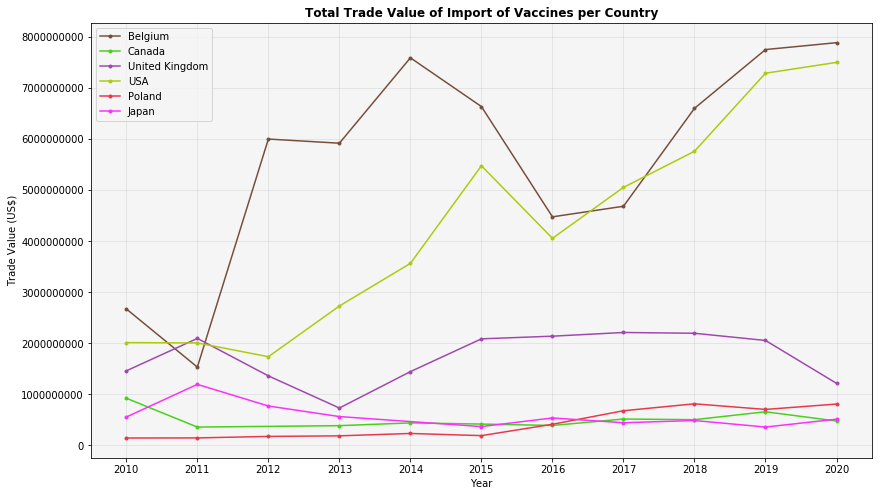

In [191]:
plot_trade_value_per_year(top_importers_all_years, country_list)

In [212]:
vaccines_df_uk_usa = vaccines_df_reduced[(vaccines_df_reduced['Year'] >= 2016) & ((vaccines_df_reduced['Reporter'] == 'United Kingdom') | (vaccines_df_reduced['Reporter'] == 'USA'))]

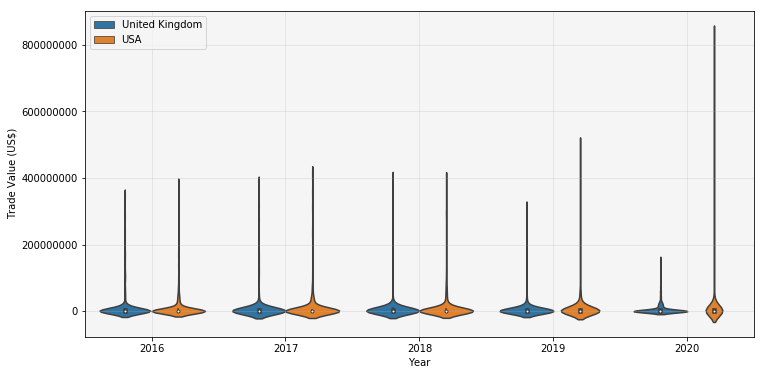

In [217]:
plt.figure(figsize=(12, 6))
sns.violinplot(x="Year", y='Trade Value (US$)', hue="Reporter", data=vaccines_df_uk_usa)
plt.ticklabel_format(style='plain', axis='y')
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

We can also visualize the results for a specific year:

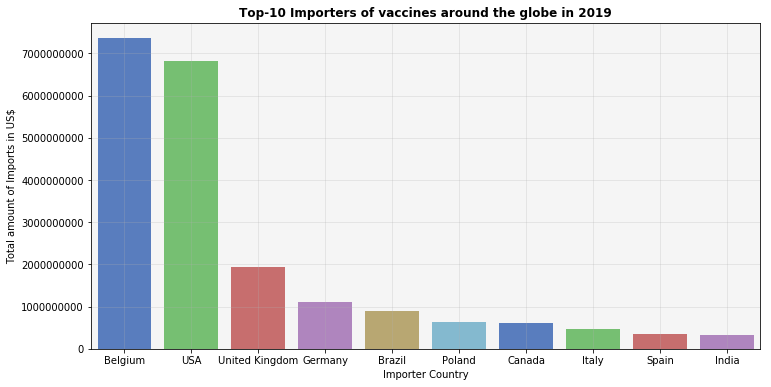

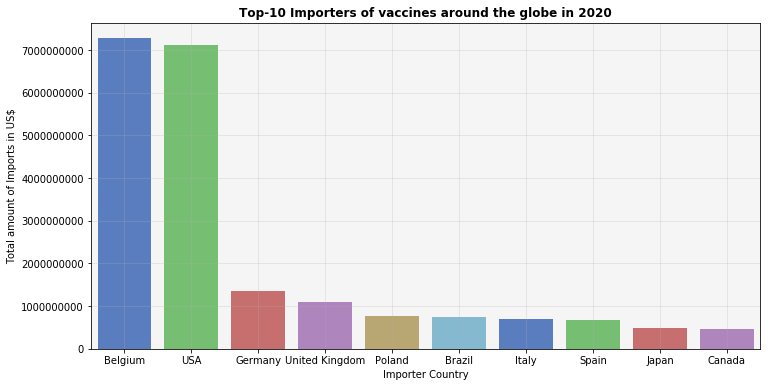

In [192]:
topn = 10

barplot_topn_countries(df=top_importers_2019, feature='Trade Value (US$)', topn=topn, kind='Import', year='2019', figsize=(12,6))

barplot_topn_countries(df=top_importers_2020, feature='Trade Value (US$)', topn=topn, kind='Import', year='2020', figsize=(12,6))

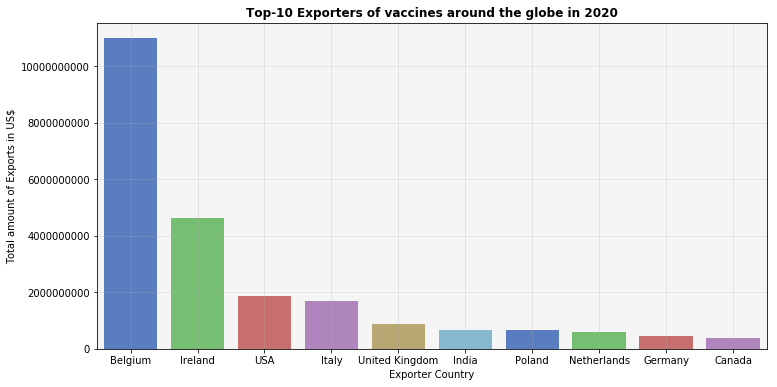

In [194]:
year = '2020'
barplot_topn_countries(df=top_exporters_2020, feature='Trade Value (US$)',topn=topn, kind='Export', year=year, figsize=(12,6))

For 2019 we can see that - except the first three countries (Belgium, USA, UK) - the rest of the countries seem to import much less compared to the top-3 importers. At the same Ireland appears to had a huge exporting activity in 2019.

<a id="forecasting_models"></a>
## Part 3 - Forecasting Models

In this part we are going to focus only at United Kingdom as the base country and perform an in depth analysis about the countries that UK is trading with, attempting to identify interesting patterns in the results. This is going to be done in two different sections. In the first one we will focus at visualizing the variations of imports by month, i.e. we will create a time series object for the base country, where each observation will be the **Total Value** of imports in a specific point in time. Aftewards, we will use the time series data to perform a _prediction_ task where we are going to test the performance of ARIMA and Holt-Winters Exponential Smoothing (HWES) models at predicting the values for 2019, based on the monthly values between 2010 and 2018. Finally, the second section of the project is focused on Network Analysis, where we will explore the importing/exporting relationship of countries but this time our main object will be a _network_ of countries, utilizing the _networkx_ (https://networkx.github.io/) python package (TO-DO in future iterations of the project).

First we are creating the objects that will contain all the information that we need for the analysis. Each object is going to represent a country and in our analysis, as we mentioned previously, we will focus on United Kingdom - but we will attempt to make the codebase as robust as possible, so that the same analysis could be easily applied for any other importer (or exporter) country. 

At this point we will leverage the class **VaccinesTradeNetwork** which has been created specifically for this project and it provides us with all the different methods & functions that we might need for the analysis. If you want more information regarding how this class is organized, feel free to have a look at the <a href='https://github.com/gpsyrou/Vaccines_Trade_Network/blob/master/VaccinesTradeNetworkClass.py' style="text-decoration: none">repository.</a> As a matter of fact, I would suggest to look at this link as it will make it much easier to understand what is happening in the background. The reason that I do not include it in the notebook is that the code is quite extensive so it would make it harder for the reader to follow along.

In [32]:
# Create an object for United Kingdom
# We can use the country parameter to focus the analysis to any other valid country
united_kingdom = VaccinesTradeNetwork(df, country='United Kingdom')

We will take into consideration all data that 1) UK is the importer country of vaccines or 2) other countries exporting **to** UK (and thus that makes UK again the importer country). This has been implemented in the *create_trade_flow_df* method, in the **VaccinesTradeNetwork** class. If we would like to change our analysis to exports instead of imports, we could just change the _tradeflow_ parameter.

In [33]:
united_kingdom_imports_df = united_kingdom.create_trade_flow_df(tradeflow='Imports',
                                                        source='Reporter',
                                                        target='Partner')

To make the analysis more straighforward to follow we will focus only at the case where the exporter country is USA (i.e. the trade value of imports of UK from USA).

In [34]:
united_kingdom_ts = united_kingdom.generateTimeSeries(partner_country='USA', timeframe='month')

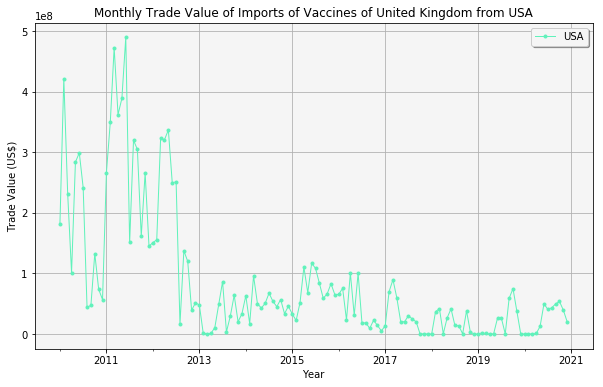

In [35]:
plt.rcParams['axes.facecolor'] = 'whitesmoke'
united_kingdom.plotTimeSeries(partner_list=['USA'], timeframe='month', figsize=(10,6))

Figure 1.1

The forecasting task will be separated into two parts. We will implement an ARIMA model to predict the monthly values for 2019, based on the values that exist for the period 2010-2018. For the second part will have the same goal but this time we will construct a Holt-Winters Exponential Smoothing model to make the predictions. Finally, we will compare the outputs of both methods and see which one is better for forecasting purposes.

<a id="arima"></a>
### Times Series Forecasting with ARIMA

At this stage we are going to fit an _ARIMA_ (Autoregressive Integrated Moving Average) model to forecast the 2019 Trade Value of UK imports of vaccines from the USA.

ARIMA(p,d,q) is a statistical method (model) for time series analysis, which helps us with the forecasting of future points of a series of observations, as well as getting a better understanding of how the data are fluctuating in time.
<a id="arima_definition"></a>
The main components of an _ARIMA_ model, are:
  
 **1.**  $AR \: (Autoregressive)$ : This means that the model is leveraging the dependent relationship between an observation and some number of lagged observations (i.e. we are regressing the variable of interest on it's prior values).
 <a id="point_2"></a>
 
 **2.**   $I \: (Integrated)$ : This is a common step to make the time series stationary, where we are subtracting an observation from an observation at the previous time step.
 
 **3.**  $MA \: (Moving\:Average)$ : It is the weighted average of the previous white noise values.
 
 **4.**   $p$: Number of lag observations in the model (lag order).
 
 **5.**   $d$: Number of times we subtracted past values from the data (degree of differencing).
 
 **6.**   $q$: Order of the moving average window (i.e. size of moving average window).
 
In the next few steps our task is to identify the values of parameters p,d,q from above in order to define the final format of the _ARIMA_ which we will use.

In [36]:
from pandas.tools.plotting import autocorrelation_plot, lag_plot
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

Now before we start building the model we should make sure that we are not violating any of the assumptions of the ARIMA models. One of these assumptions is that the time series is **stationary** (i.e. the mean and the variance remain constant over time). Please note that when we are saying that a series is stationary we don't mean that the series does not change over time - it means that the _way_ that the series is changing does not vary over time.

By looking at Figure 1.1 we can see that the time series in our case is not stationary and we have a **decreasing trend** (we will name this 'trend'), along with **seasonal trends** (we will name this 'seasonality'). As a reminder:

1) **Trend**: A time series is said to have a trend when there is a pattern in the way that series is changing over time (not specific to a year). 

2) **Seasonality**: When a time series is displaying variations that occur at specific time intervals (e.g. every 4 months or every year), then we are saying that the series exhibits signs of seasonality.


<a id="autocorel_lag_plot"></a>
#### Autocorellation, Lag Plot and Stationarity


At first we look at the **autocorrelation plot (ACF)** of the time series. This plot helps us identify a statistically significant amount of lags for the time series (i.e the lag order). This can be identified by looking at which point our series is "cutting" the upper bound of the confidence band, which is the significant range.

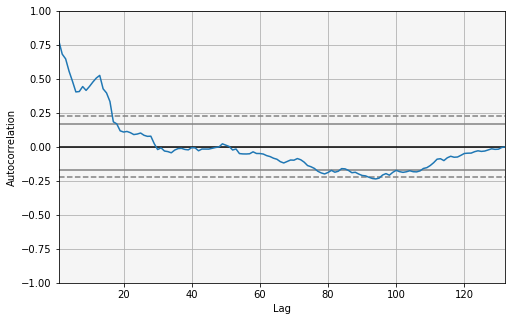

In [37]:
plt.figure(figsize = (8,5))
autocorrelation_plot(united_kingdom_ts['Trade Value (US$)'])

By looking at the plot we can infer that there is a positive correlation between lags 1-30, but it seems to be significant at the first 1 to 18 lags.
Thus a good starting point would be at 8-12 lags.

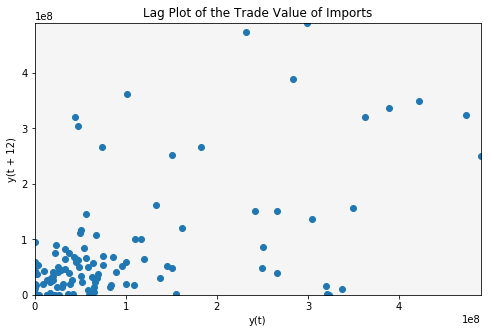

In [38]:
lag_order = 12

# Create a Lag plot
tnf.create_lag_plot(united_kingdom_ts['Trade Value (US$)'], lag = lag_order)

A lag plot is a special type of scatter plot with the two variables $(X,Y)$ “lagged”.

A “lag” is a fixed amount of passing time; One set of observations in a time series is plotted (lagged) against a second, later set of data. 
The $k$th lag is the time period that happened “$k$” time points before time i.
(reference: https://www.statisticshowto.datasciencecentral.com/lag-plot/)

In our case we can see that we have a - somehow - positive correlation and there is a linear pattern (suggesting autocorellation) between time $t$ and $t-k$ where $k$ = lag order.

To check and evaluate the time series for stationarity we will be using a custom function that is using some visual representation as well as the _Dickey-Fuller_ test.In this test, the null hypothesis ($H_0$) is that the Time Series is non-stationary.

In [39]:
# Function that calculates the rolling mean and standard deviation, as well as performing the Dickey-Fuller Test
def check_stationarity(time_series, window, figsize=(10,6)):
    """
    Function that calculates the rolling mean and standard deviation, 
    as well as performing the Dickey-Fuller Test
    
    Parameters:
    
    time_series: time series as a dataframe/series object
    window: size of the rolling average window
    
    """ 
    # Calculating rolling mean and standard deviation
    rolling_mean = time_series.rolling(window).mean()
    rolling_std = time_series.rolling(window).std()
    
    plt.figure(figsize=figsize)
    plt.plot(time_series, color = 'blue',label = 'Original TS')
    plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolling_std, color = 'black', label = 'Rolling St.Dev.')
    plt.legend(loc = 'best')
    plt.grid(True, color = 'lightgrey')
    plt.title('Rolling Mean & Standard Deviation of the Trade Value of Vaccines', fontsize = 10)
    
    # Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    fuller_test = adfuller(time_series, autolag = 'AIC')
    results_ts = pd.Series(fuller_test[0:4], index = ['Test Statistic','P-value','#Lags Used','Number of Observations Used'])
    for key,value in fuller_test[4].items():
        results_ts['Critical Value (%s)'%key] = value
    print(results_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.903550
P-value                          0.330393
#Lags Used                      13.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


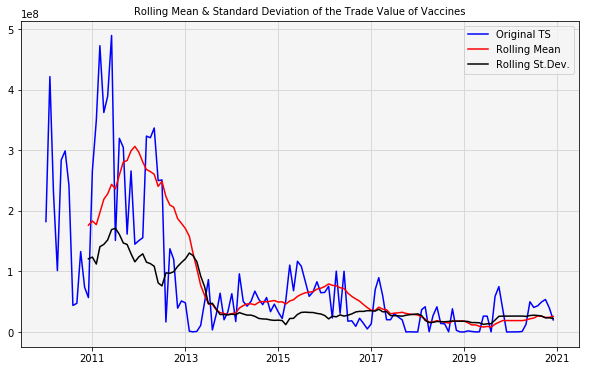

In [40]:
check_stationarity(time_series=united_kingdom_ts['Trade Value (US$)'], window=lag_order, figsize=(10,6))

We can see that our time series is not stationary yet, as the test statistic is more that the critical values (we are not looking at the absolute values). Therefore we **fail to reject** the null hypothesis. This can also be infered by looking at the plot above, where we can see that both the mean and the standard deviation are following the trend of the series.

The reason why this time series is not stationary lies to the fact that we have a clear trend and seasonality in our data, as already mentioned above. One of the most common ways to resolve this issue is by using a technique called _differencing_ (point 2 at ARIMA model explanation <a href='#point_2' style="text-decoration: none\">above</a>). Hence, when it's time to run the ARIMA model we have to make sure to include an $I$ (integrated) parameter - which will give us the value of the differentiation paremeter (i.e. how many times we are differencing an observation).

This will be automatically applied in our algorithm below as we can assing the value $d=1$ , and the algorithm with understand that we want a first order of differencing. To get a better understanding of how this makes our series stationary we can look at the process below:

In [41]:
trade_value = united_kingdom_ts['Trade Value (US$)']
trade_value_diff = trade_value - trade_value.shift()

# This is necessary as with differencing we can't calculate the
# previous value of the first observation (as there is no data)
trade_value_diff.dropna(inplace = True)

Results of Dickey-Fuller Test:
Test Statistic                  -3.725041
P-value                          0.003774
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


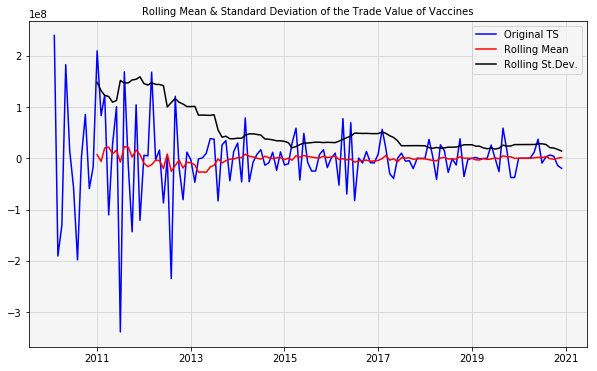

In [42]:
check_stationarity(time_series=trade_value_diff, window=lag_order, figsize=(10,6))

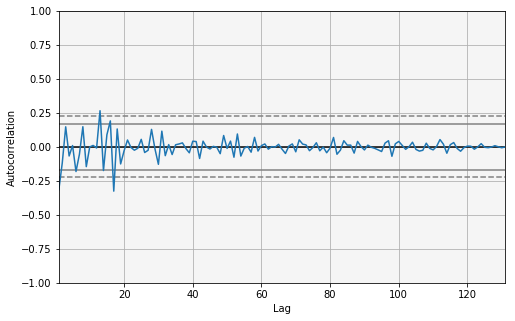

In [43]:
plt.figure(figsize = (8,5))
autocorrelation_plot(trade_value_diff)

Hence, we can see that with first level order of differencing (differencing one time) we get the result that we wanted.

Now to define the values for $p$ and $q$, we will use the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function). The ACF is helping us to measure the correlation of our time series with a lagged version of itself, for a specific lag. The PACF is similar to ACF but we are also excluding the variations explained already between an observation and its lagged value.

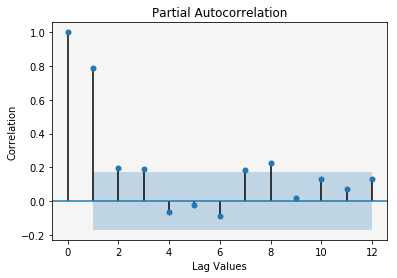

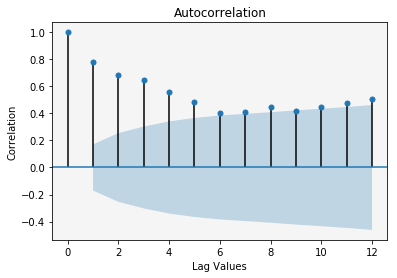

In [44]:
# Partial Autocorrelation Plot (PACF) - Identify p
tnf.plot_acf_pacf(united_kingdom_ts['Trade Value (US$)'], lag=lag_order, kind='pacf')

# Autocorrelation plot - Identify q
tnf.plot_acf_pacf(united_kingdom_ts['Trade Value (US$)'], lag=lag_order, kind='acf')

The PACF and ACF plots indicating that we have clear statistical significance for lags 1,2,3,7 or 8 for PACF (giving us the $p$ parameter) and lags 1 to 5 (giving us the $q$ paremeter).

<a id="arima_creation"></a>
### Fitting the ARIMA model

Now we are going to split our dataset into train and test sets, where the training set will contain the data for period 2010-2018, and the test set will contain data for 2019. The main goal is - based on the training data - how well we can predict the future values for 2019.

In [45]:
def split_test_train(df, num_months_test = 1):
    """
    Split a Time Series object into Train and Test sets.
    
    Parameters:
    df: Series object
    num_months_test: Number of months to keep as test set (rest will be training set)
    
    """
    train_set = df.iloc[0:len(df)-num_months_test]
    test_set = df.iloc[len(df)-num_months_test:len(df)]
    
    return train_set, test_set

In [46]:
train, test = split_test_train(united_kingdom_ts['Trade Value (US$)'], num_months_test=12)

In [47]:
train.shape, test.shape

((120,), (12,))

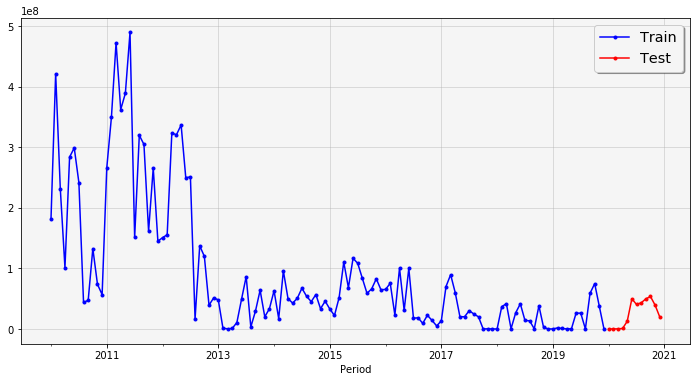

In [48]:
# Plot train and test sets
plt.figure(figsize=(12,6))
train.plot(marker = '.', color = 'blue', label = 'Train')
test.plot(marker = '.', color = 'red', label = 'Test')
plt.legend(loc = 'best', shadow = True, fontsize = 'x-large')
plt.grid(True, alpha=0.5)
plt.show()

We can create multiple ARIMA models and test the different values for p,d,q parameters that we identified above, and we will use the minimum **AIC (Akaike information criterion)** value to choose the optimal model. As a reminder, AIC is an estimator which is commonly used to compare models (model selection) that are using the same data. Please note that the AIC criterion does not provide any information if the model fits the data well. Instead it's a way to measure the quality of a model _compared_ to others. The AIC criterion is being described from the following formula:

\begin{equation}
\text{AIC} = 2k - 2\ln(\hat{L})
\end{equation}

where $\hat{L}$ is the maximum value of the likelihood function, and $k$ is the number of the estimated parameters.

In [49]:
# Possible values for p,d,q paremeters and all of their combinations
p = [2, 3, 7, 8, 12] 
d = [1]
q = [2, 3, 4]

import itertools
param_combinations = list(itertools.product(p, d, q))

In [50]:
import warnings
warnings.filterwarnings('ignore')

AIC_results = {}
for perm in param_combinations:
    model = ARIMA(train, order = (perm[0], perm[1], perm[2]))
    model_output = model.fit(disp=0)
    AIC_results[perm] = model_output.aic
    print(f'Paremeter combination: {perm} - AIC score: {model_output.aic}')

Paremeter combination: (2, 1, 2) - AIC score: 4638.803238929007
Paremeter combination: (2, 1, 3) - AIC score: 4638.127449965116
Paremeter combination: (2, 1, 4) - AIC score: 4639.8626273525215
Paremeter combination: (3, 1, 2) - AIC score: 4637.987418272536
Paremeter combination: (3, 1, 3) - AIC score: 4633.004161275971
Paremeter combination: (3, 1, 4) - AIC score: 4634.20562366812
Paremeter combination: (7, 1, 2) - AIC score: 4638.852519515909
Paremeter combination: (7, 1, 3) - AIC score: 4635.945168992839
Paremeter combination: (7, 1, 4) - AIC score: 4640.4572576057135
Paremeter combination: (8, 1, 2) - AIC score: 4643.655786077333
Paremeter combination: (8, 1, 3) - AIC score: 4641.421875829529
Paremeter combination: (8, 1, 4) - AIC score: 4643.361248830721
Paremeter combination: (12, 1, 2) - AIC score: 4621.8425950317005
Paremeter combination: (12, 1, 3) - AIC score: 4623.830299782802
Paremeter combination: (12, 1, 4) - AIC score: 4642.239315654757


We are going to pick the set of parameters that are producing the minimum AIC score, and run our final ARIMA model based on these parameters.

In [52]:
optml_params = min(AIC_results.items(), key=lambda x: x[1])[0]

p, d, q = optml_params[0], optml_params[1], optml_params[2]

print('Optimal values are: p={0}, d={1}, q={2}'.format(p, d, q))

Optimal values are: p=12, d=1, q=2


Note that in the model below we are going to predict the first value for 01/01/2019, and then this value becomes an input value for the next prediction (i.e. 01/02/2019). In simple words, every time we are making a prediction, then this predictions becomes an observation based on which we are making any further prediction.
<a id="arima_results"></a>

In [53]:
# Run the final ARIMA model with the optimal values
predicted_values_arima = []
series_updated = [x for x in train]

for t in range(len(test)):
    model = ARIMA(series_updated, order=(p,d,q))
    model_output = model.fit(disp=0)
    pred = model_output.forecast()
    yhat = pred[0]
    predicted_values_arima.append(yhat)
    obs = test[t]
    series_updated.append(obs)
    print('predicted=%.2f, expected=%.2f' % (yhat, obs))

predicted=23616707.48, expected=98131.00
predicted=13909278.42, expected=140782.00
predicted=-18917415.72, expected=239561.00
predicted=-27807005.54, expected=867911.00
predicted=1489244.82, expected=12655632.00
predicted=19999997.70, expected=49928814.00
predicted=27940365.98, expected=40565012.00
predicted=27263437.65, expected=43259134.00
predicted=57744603.52, expected=49667449.00
predicted=72927999.21, expected=53701177.00
predicted=65699269.68, expected=39445427.00
predicted=31540691.46, expected=19962228.00


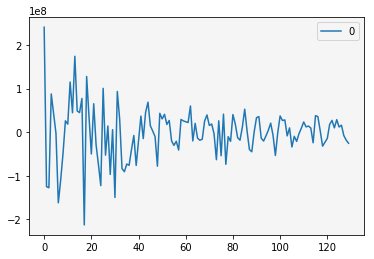

In [54]:
# Plot the residual errors
resid = pd.DataFrame(model_output.resid)
resid.plot()

                  0
count  1.300000e+02
mean  -1.128337e+06
std    5.942196e+07
min   -2.127395e+08
25%   -2.260237e+07
50%    3.647926e+06
75%    2.844964e+07
max    2.405029e+08


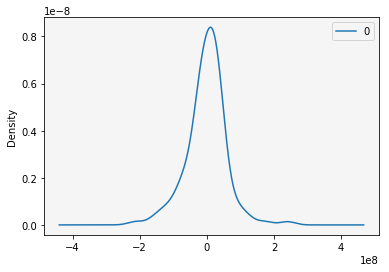

In [55]:
# Plot density of the residuals
resid.plot(kind='kde')
print(resid.describe())

<a id="hwes"></a>
### Holt-Winters Exponential Smoothing
<a id="hwes_definition"></a>

In general, the Exponential Smoothing techniques are predicting future values of a time series by using a weighted average of all previous values, where the weights are getting adjusted with recent values getting higher weights and vice versa for the older historical values of the series. In other words, this family of methods assumes that more recent values of a time series are more important than older ones for predicting the future observations (and thus they getting assigned higher weights). This is something very useful in our case where , even though we care about the values of the series in the past, we want to give higher importance to values closer to the time period that we want to predict. During _Exponential Smoothing_ method the forecasts are calculated as follows: 

\begin{equation}
  \hat{y}_{t+1|t} = \alpha y_t + \alpha(1-\alpha) y_{t-1} + \alpha(1-\alpha)^2 y_{t-2}+ \cdots,   
\end{equation}

where $a$ is the smoothing parameter. Therefore we can see that in this family of models the forecast for timestep ${t+1}$, is a _weighted average_ of the previous observations adjusted by the smoothing parameter. We can also write the equation above as:

\begin{align*}
  \text{forecast equation}  && \hat{y}_{t+h|t} & = \ell_{t} \\
  \text{smoothing equation} && \ell_{t} & = \alpha y_{t} + (1 - \alpha)\ell_{t-1},
\end{align*}

On the other hand, the Exponential Smoothing models do not tend to work well with series that display _trend_ and _seasonal_ variations.

This problem can be solved by using a more sophisticated type of exponential smoothing technique called **Holt-Winters Exponential Smoothing (HWES)**. 

The Holter-Winters exponential smoothing method is using an exponential window function where we are assigning decreasing weights in the past observations depending how 'far' they are compared to the prediction point in time, while at the same time taking into account concepts like trend and seasonality. This happens by utilizing 3 smoothing equations during our forecast, one for the level, one for the trend and one for the seasonal component.

In our project we are going to use the **additive method** of the component which is the preferred method when the seasonal variations in the series are almost constant. This method can be described with the following equations:

\begin{align*}
  \text{forecast equation} && \hat{y}_{t+h|t} &= \ell_{t} + hb_{t} + s_{t+h-m(k+1)} \\
  \text{level equation} && \ell_{t} &= \alpha(y_{t} - s_{t-m}) + (1 - \alpha)(\ell_{t-1} + b_{t-1})\\
  \text{trend equation} && b_{t} &= \beta^*(\ell_{t} - \ell_{t-1}) + (1 - \beta^*)b_{t-1}\\
  \text{seasonal equation} && s_{t} &= \gamma (y_{t}-\ell_{t-1}-b_{t-1}) + (1-\gamma)s_{t-m},
\end{align*}

From the equations above $α$ describes the smoothing factor for the level, $β$ the smoothing factor for the trend and $γ$ the smoothing factor for seasonality. Note that $m$ describes the seasonality frequency. For example if in our data we observe seasonality appearing every quarter then we would use $m=4$, or $m=12$ for monthly.
<a id="hwes_creation"></a>

In [56]:
# Additive Holt Winter's Exponential Smoothing method (Additive HWES)
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

train, test = tnf.split_test_train(united_kingdom_ts['Trade Value (US$)'], num_months_test=12)

In [57]:
aic_scores = {}
for m in range(2, len(test)+1):
    hwes_model = ExponentialSmoothing(train, seasonal='add', trend='add', seasonal_periods=m).fit()
    predicted_values = hwes_model.forecast(steps=len(test))
    aic_scores[m] = hwes_model.aic

In [58]:
aic_scores_results = sorted(aic_scores.items(), key=lambda kv: kv[1])
aic_scores_results

[(4, 4355.821810030624),
 (3, 4365.818740419113),
 (5, 4371.045148452104),
 (8, 4378.4333926023155),
 (2, 4381.796442228696),
 (6, 4393.868733566921),
 (7, 4394.301098850355),
 (12, 4409.931946571245),
 (9, 4425.426450342629),
 (11, 4430.149951253819),
 (10, 4441.264275993112)]

In [59]:
optimal_seasonal_prd = aic_scores_results[0][0]
optimal_seasonal_prd

4

In [60]:
hwes_model = ExponentialSmoothing(train, seasonal='add', trend='add', seasonal_periods=optimal_seasonal_prd)
hwes_model_fit = hwes_model.fit()
predicted_values_hwes = hwes_model_fit.forecast(steps=len(test))

In [61]:
for pred in zip(predicted_values_hwes, test):
    print('predicted=%.2f, expected=%.2f' % (pred[0], pred[1]))

predicted=34170512.31, expected=98131.00
predicted=44195858.63, expected=140782.00
predicted=23300841.83, expected=239561.00
predicted=15562495.67, expected=867911.00
predicted=34170512.29, expected=12655632.00
predicted=44195858.61, expected=49928814.00
predicted=23300841.81, expected=40565012.00
predicted=15562495.64, expected=43259134.00
predicted=34170512.26, expected=49667449.00
predicted=44195858.58, expected=53701177.00
predicted=23300841.78, expected=39445427.00
predicted=15562495.62, expected=19962228.00


<a id="hwes_results"></a>

<a id="conclusion"></a>
### Model Comparison and Conclusion

Both of the algorithms presented above are using similar logic & ideas in order to predict future values. At their core, both methods are decomposing the time series into three different components - trend, seasonality and white noise - and they use the first two (white noise is not predictable) in order to predict future values.

A main difference between the models is that the ARIMA model is using a Moving Average component which means that we are smoothing the data by taking an average of the past observations and assigning to them equal weights. On the other hand, as we saw above the HWES model is assigning exponentially decreasing weights to older observations.

At first we can compare the predictions visually:

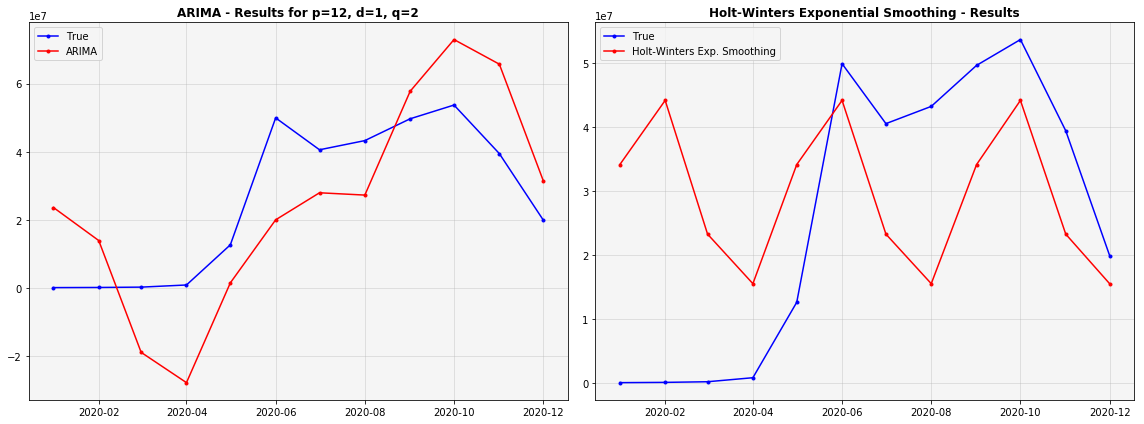

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# ARIMA plot
plt.subplot(1, 2, 1)
plt.plot(test, marker='.', color= 'blue', label='True')
plt.plot(pd.Series(predicted_values_arima, index=test.index), marker='.', color='red', label='ARIMA')
plt.grid(True, alpha=0.4),
plt.title(f'ARIMA - Results for p={p}, d={d}, q={q}', fontweight='bold')
plt.legend(loc='upper left')

# HWES plot
plt.subplot(1, 2, 2)
plt.plot(test.index, test, marker='.', color= 'blue', label='True')
plt.plot(predicted_values_hwes.index, predicted_values_hwes, marker='.', color='red', label='Holt-Winters Exp. Smoothing')
plt.grid(True, alpha=0.4)
plt.title('Holt-Winters Exponential Smoothing - Results', fontweight='bold')
plt.legend(loc='upper left')

plt.tight_layout()

From the plots above it's hard to make an inference about which model might be more accurate for our problem. At a first glance someone might think that the HWES model is performing better as we can see that there are some instances where the expected/predicted values are very close. On the other hand, the ARIMA model seems to be better at capturing big "jumps" up or down in the series.



To do a numerical model comparison and evaluation, we are going to use a metric called **Root Mean Square Error (RMSE)**, which is the standard deviation of the residuals (prediction errors). 
Residuals are a measure of how far from the predicted line data points are. Therefore,
RMSE is a measure of how spread out these residuals are - i.e. it tells us how concentrated the data is around the line of best fit - which in our case is the predicted line (red color in the plots above).

RMSE is described by the following formula:
\begin{equation}
RMSE = \sqrt\frac{\sum_{i=1}^{n}   \left(y_{i} - \hat{y}\right)^{2}}   {n}
\end{equation}

In [63]:
def compute_RMSE(true_val, predicted_val, p_output=True) -> float:
    """
    Compute the Root Mean Squared Error (RMSE) for two series - one describing
    the real values and the other the predicted.
    """
    from sklearn.metrics import mean_squared_error
    rms = np.sqrt(mean_squared_error(np.array(true_val), predicted_val))
    if p_output:
        print('RMSE: {0}'.format(rms))
    return rms

In [64]:
rmse_arima = compute_RMSE(true_val=test, predicted_val=predicted_values_arima, p_output=False)
rmse_hwes = compute_RMSE(true_val=test, predicted_val=predicted_values_hwes, p_output=False)

In [65]:
from IPython.display import display, HTML

results_df = pd.DataFrame({"Method": ['ARIMA', 'Holt-Winters Exponential Smoothing'], "RMSE": [rmse_arima, rmse_hwes]})

display(HTML(results_df.to_html(index=False)))

Method,RMSE
ARIMA,1.963381e+07
Holt-Winters Exponential Smoothing,2.239969e+07


As we can see, in contrast with what we had initially thought about the results from the visualizations, appears that the ARIMA model is more successful at minimizing the RMSE. The HWES method seems to be providing an aggregated repetitive pattern while failing to account for sudden fluctuations in the series. On the other hand, even though ARIMA is not very accurate at predicting the *exact* real value (we can see for example that a few predictions from HWES are falling pretty close to the real values) it's much better in capturing the overal trend of the series, something that leads to a smaller RMSE.

Finally, we can say that both of these models are easy to build and powerful models for forecasting tasks. The difference in the RMSE, even though it exists, we can't say that its so significant that it would make the argument of ARIMA vs HWES to go easily in favor of the former one. ARIMA seems to be more powerful at capturing the overal trend of the series, while the HWES it's an easier (and faster) model to build.